In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import dill

import keras as k
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input, merge, UpSampling2D
from keras.layers.merge import concatenate

import cv2
from tqdm import tqdm


Using Theano backend.


In [10]:
with open('tiffs.pkl', 'rb') as in_strm:
    all_info = dill.load(in_strm)
x_train = all_info[0]
x_test = all_info[1]
y_train = all_info[2]
y_test = all_info[3]
label_map = all_info[4]
inv_label_map = all_info[5]

In [15]:
def get_unet():
    inputs1 = Input(shape=(32, 32, 4))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs1)
    conv12 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv12)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv23 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv23)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv32 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv32)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv42 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv42)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv52 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv52), conv42], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv62 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv62), conv32], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv72 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv72), conv23], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv82 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv82), conv12], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv92 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    flat = Flatten()(conv92)
    dense1 = Dense(128, activation='relu')(flat)
    drop = Dropout(0.5)(dense1)
    dense2 = Dense(17, activation='sigmoid')(drop)

    model = Model(inputs=inputs1, outputs=dense2)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [16]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(35000, 32, 32, 4)
(5479, 32, 32, 4)
(35000, 17)
(5479, 17)


In [17]:
print (k.__version__)
model = get_unet()

model.fit(x_train, y_train, batch_size=128, epochs=8, verbose=1,
         validation_data=(x_test, y_test))

model.save_weights('unets/unet_1_weights.h5')
from sklearn.metrics import fbeta_score

p_valid = model.predict(x_test, batch_size=128)
print(y_test)
print(p_valid)
print(fbeta_score(y_test, np.array(p_valid) > 0.2, beta=2, average='samples'))

2.0.4
Train on 35000 samples, validate on 5479 samples
Epoch 1/8
35000/35000 [==============================] - 2148s - loss: 0.2915 - acc: 0.8964 - val_loss: 0.2098 - val_acc: 0.9137
Epoch 2/8
35000/35000 [==============================] - 2100s - loss: 0.2089 - acc: 0.9204 - val_loss: 0.1771 - val_acc: 0.9305
Epoch 3/8
35000/35000 [==============================] - 2214s - loss: 0.1824 - acc: 0.9312 - val_loss: 0.1561 - val_acc: 0.9401
Epoch 4/8
35000/35000 [==============================] - 2257s - loss: 0.1695 - acc: 0.9366 - val_loss: 0.1479 - val_acc: 0.9434
Epoch 5/8
35000/35000 [==============================] - 2265s - loss: 0.1589 - acc: 0.9404 - val_loss: 0.1505 - val_acc: 0.9421
Epoch 6/8
35000/35000 [==============================] - 2266s - loss: 0.1534 - acc: 0.9422 - val_loss: 0.1457 - val_acc: 0.9455
Epoch 7/8
35000/35000 [==============================] - 2265s - loss: 0.1485 - acc: 0.9436 - val_loss: 0.1384 - val_acc: 0.9460
Epoch 8/8
35000/35000 [===================

Time to see what the unet got right vs what it got wrong via confusion matrix for each label.
I'm not sure why it says water in each graph...

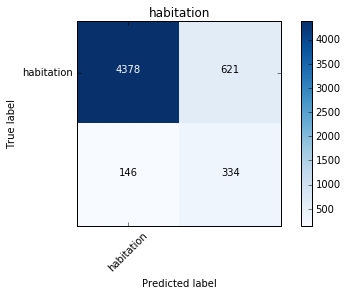

Stats for  habitation
Accuracy (true positive + true negative) / total:  0.860010950903
FPR (when actually no, how often does it say yes):  0.124224844969
TPR aka Recall (when actually yes, how often does it say yes):  0.695833333333
Precision (when predicts yes, how often is it right):  0.349738219895
Prevalence (how often does actual yes occur in sample):  0.0876072275963


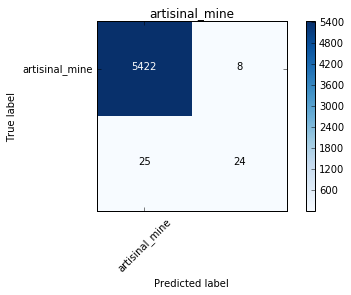

Stats for  artisinal_mine
Accuracy (true positive + true negative) / total:  0.993977003103
FPR (when actually no, how often does it say yes):  0.00147329650092
TPR aka Recall (when actually yes, how often does it say yes):  0.489795918367
Precision (when predicts yes, how often is it right):  0.75
Prevalence (how often does actual yes occur in sample):  0.00894323781712


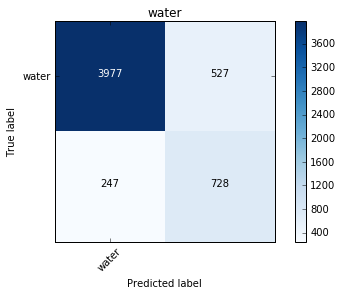

Stats for  water
Accuracy (true positive + true negative) / total:  0.858733345501
FPR (when actually no, how often does it say yes):  0.117007104796
TPR aka Recall (when actually yes, how often does it say yes):  0.746666666667
Precision (when predicts yes, how often is it right):  0.580079681275
Prevalence (how often does actual yes occur in sample):  0.177952181055


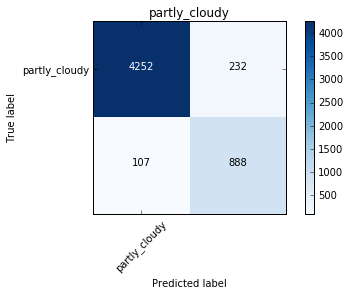

Stats for  partly_cloudy
Accuracy (true positive + true negative) / total:  0.93812739551
FPR (when actually no, how often does it say yes):  0.0517395182872
TPR aka Recall (when actually yes, how often does it say yes):  0.892462311558
Precision (when predicts yes, how often is it right):  0.792857142857
Prevalence (how often does actual yes occur in sample):  0.181602482205


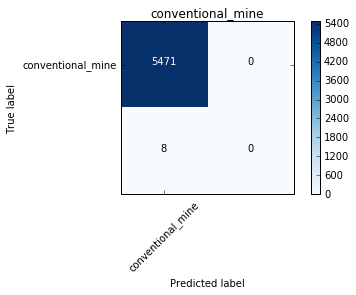

Stats for  conventional_mine
Accuracy (true positive + true negative) / total:  0.99853987954
FPR (when actually no, how often does it say yes):  0.0
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  nan
Prevalence (how often does actual yes occur in sample):  0.00146012045994


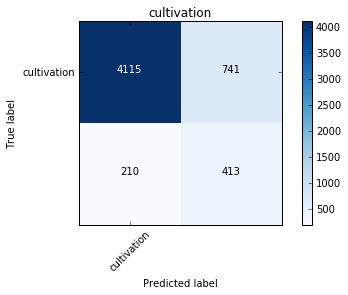

Stats for  cultivation
Accuracy (true positive + true negative) / total:  0.826428180325
FPR (when actually no, how often does it say yes):  0.152594728171
TPR aka Recall (when actually yes, how often does it say yes):  0.662921348315
Precision (when predicts yes, how often is it right):  0.357885615251
Prevalence (how often does actual yes occur in sample):  0.113706880818


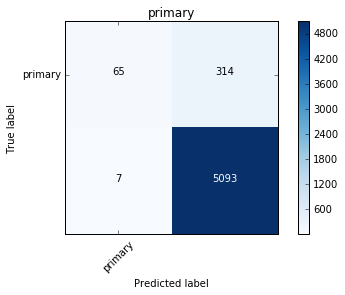

Stats for  primary
Accuracy (true positive + true negative) / total:  0.941412666545
FPR (when actually no, how often does it say yes):  0.828496042216
TPR aka Recall (when actually yes, how often does it say yes):  0.99862745098
Precision (when predicts yes, how often is it right):  0.941927131496
Prevalence (how often does actual yes occur in sample):  0.93082679321


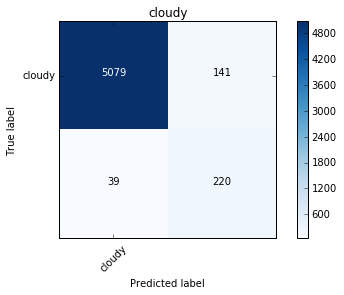

Stats for  cloudy
Accuracy (true positive + true negative) / total:  0.967147289651
FPR (when actually no, how often does it say yes):  0.0270114942529
TPR aka Recall (when actually yes, how often does it say yes):  0.849420849421
Precision (when predicts yes, how often is it right):  0.609418282548
Prevalence (how often does actual yes occur in sample):  0.0472713998905


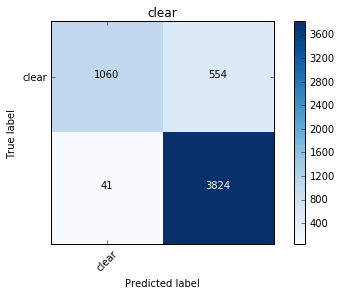

Stats for  clear
Accuracy (true positive + true negative) / total:  0.891403540792
FPR (when actually no, how often does it say yes):  0.343246592317
TPR aka Recall (when actually yes, how often does it say yes):  0.989391979301
Precision (when predicts yes, how often is it right):  0.873458200091
Prevalence (how often does actual yes occur in sample):  0.705420697208


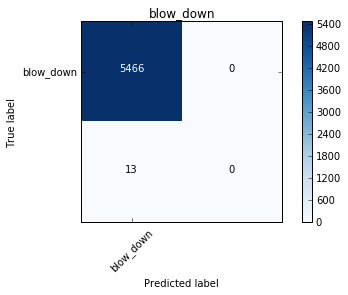

Stats for  blow_down
Accuracy (true positive + true negative) / total:  0.997627304253
FPR (when actually no, how often does it say yes):  0.0
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  nan
Prevalence (how often does actual yes occur in sample):  0.0023726957474


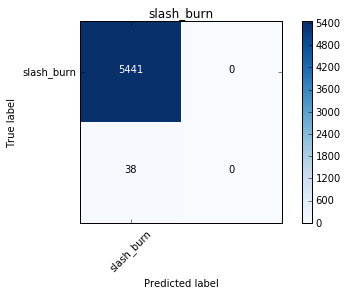

Stats for  slash_burn
Accuracy (true positive + true negative) / total:  0.993064427815
FPR (when actually no, how often does it say yes):  0.0
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  nan
Prevalence (how often does actual yes occur in sample):  0.00693557218471


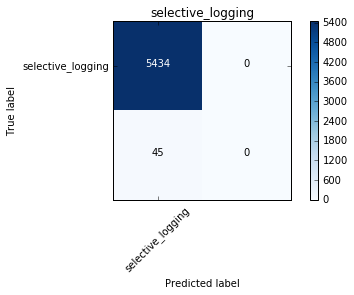

Stats for  selective_logging
Accuracy (true positive + true negative) / total:  0.991786822413
FPR (when actually no, how often does it say yes):  0.0
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  nan
Prevalence (how often does actual yes occur in sample):  0.00821317758715


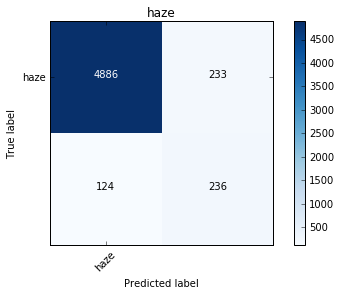

Stats for  haze
Accuracy (true positive + true negative) / total:  0.934842124475
FPR (when actually no, how often does it say yes):  0.045516702481
TPR aka Recall (when actually yes, how often does it say yes):  0.655555555556
Precision (when predicts yes, how often is it right):  0.503198294243
Prevalence (how often does actual yes occur in sample):  0.0657054206972


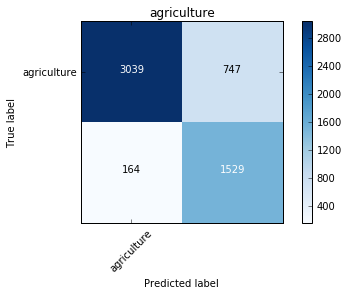

Stats for  agriculture
Accuracy (true positive + true negative) / total:  0.833728782625
FPR (when actually no, how often does it say yes):  0.197305863708
TPR aka Recall (when actually yes, how often does it say yes):  0.903130537507
Precision (when predicts yes, how often is it right):  0.671792618629
Prevalence (how often does actual yes occur in sample):  0.308997992334


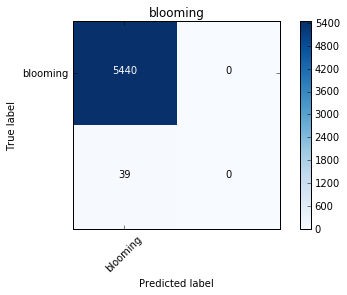

Stats for  blooming
Accuracy (true positive + true negative) / total:  0.992881912758
FPR (when actually no, how often does it say yes):  0.0
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  nan
Prevalence (how often does actual yes occur in sample):  0.0071180872422


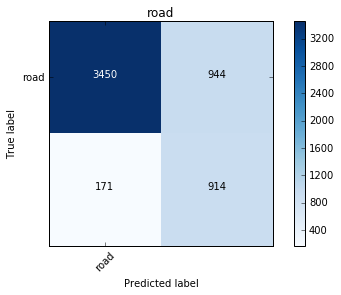

Stats for  road
Accuracy (true positive + true negative) / total:  0.796495710896
FPR (when actually no, how often does it say yes):  0.214838416022
TPR aka Recall (when actually yes, how often does it say yes):  0.842396313364
Precision (when predicts yes, how often is it right):  0.491926803014
Prevalence (how often does actual yes occur in sample):  0.198028837379


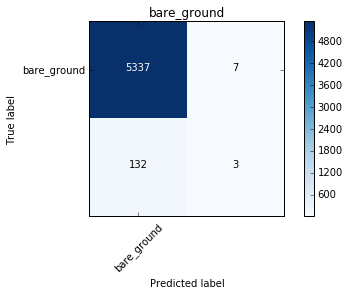

Stats for  bare_ground
Accuracy (true positive + true negative) / total:  0.974630407009
FPR (when actually no, how often does it say yes):  0.00130988023952
TPR aka Recall (when actually yes, how often does it say yes):  0.0222222222222
Precision (when predicts yes, how often is it right):  0.3
Prevalence (how often does actual yes occur in sample):  0.0246395327615


In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



for i in inv_label_map.keys():
    label = inv_label_map[i]
    cnf_matrix = confusion_matrix(y_test[:,i], p_valid[:,i]>0.2)
    plot_confusion_matrix(cnf_matrix, classes=[label], normalize=False,
                      title=label)
    total = cnf_matrix[0][0] + cnf_matrix[0][1] + cnf_matrix[1][0] + cnf_matrix[1][1]
    actualYes = cnf_matrix[1][0] + cnf_matrix[1][1]
    actualNo = cnf_matrix[0][0] + cnf_matrix[0][1]
    predYes = cnf_matrix[0][1] + cnf_matrix[1][1]
    plt.show()
    print("Stats for ", label)
    print("Accuracy (true positive + true negative) / total: ", (cnf_matrix[1][1] + cnf_matrix[0][0])/total)
    print("FPR (when actually no, how often does it say yes): ", cnf_matrix[0][1]/actualNo)
    print("TPR aka Recall (when actually yes, how often does it say yes): ", cnf_matrix[1][1]/actualYes)
    print("Precision (when predicts yes, how often is it right): ", cnf_matrix[1][1]/predYes)
    print("Prevalence (how often does actual yes occur in sample): ", actualYes/total)



Testing to make sure data collection is correct, because it sure seems off...
Basing my code off here: https://www.kaggle.com/robinkraft/getting-started-with-the-data-now-with-docs
And then also comparing to here: https://www.kaggle.com/anokas/data-exploration-analysis

In [151]:
labels_df = pd.read_csv('DB/train_v2.csv')
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

print(labels_df[label_list].sum()) 

haze                  2697
primary              37513
agriculture          12315
clear                28431
water                 7411
habitation            3660
road                  8071
cultivation           4477
slash_burn             209
cloudy                2089
partly_cloudy         7261
conventional_mine      100
bare_ground            862
artisinal_mine         339
blooming               332
selective_logging      340
blow_down               98
dtype: int64


After lots of debugging, it turns out making the indices for the labels array is not consistent every time.
Example: One time will encode a 17 length vector V with V[0] being if primary is a label, and V[1] if cloudy is a label, etc. The next time it might encode V[0] as cloudy, and V[1] as primary, etc.
This mother fucking shit. I am so mad.